# Packages

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import glob 



%matplotlib inline

# Data Preprocessing

In [3]:
# download zip file from github
!wget https://raw.githubusercontent.com/Abtinmy/CS-SBU-NeuralNetwork/main/assignments/Assignment%202/Dataset.zip

--2023-04-08 11:52:43--  https://raw.githubusercontent.com/Abtinmy/CS-SBU-NeuralNetwork/main/assignments/Assignment%202/Dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66764119 (64M) [application/zip]
Saving to: ‘Dataset.zip’

Dataset.zip         100%[===================>]  63.67M   219MB/s    in 0.3s    

2023-04-08 11:52:44 (219 MB/s) - ‘Dataset.zip’ saved [66764119/66764119]



In [4]:
# create folder 
!mkdir dataset

In [5]:
# unzip data
!unzip /content/Dataset.zip -d /content/dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/mnist_middle_columns/26957.jpg  
  inflating: /content/dataset/mnist_middle_columns/83.csv  
  inflating: /content/dataset/mnist_middle_columns/4921.csv  
  inflating: /content/dataset/mnist_middle_columns/34436.jpg  
  inflating: /content/dataset/mnist_middle_columns/28228.csv  
  inflating: /content/dataset/mnist_middle_columns/11910.csv  
  inflating: /content/dataset/mnist_middle_columns/24492.jpg  
  inflating: /content/dataset/mnist_middle_columns/32617.jpg  
  inflating: /content/dataset/mnist_middle_columns/57638.csv  
  inflating: /content/dataset/mnist_middle_columns/37617.csv  
  inflating: /content/dataset/mnist_middle_columns/35601.jpg  
  inflating: /content/dataset/mnist_middle_columns/42223.csv  
  inflating: /content/dataset/mnist_middle_columns/24519.csv  
  inflating: /content/dataset/mnist_middle_columns/40571.csv  
  inflating: /content/dataset/mnist_middle_columns/54769.jpg  
  inflat

In [6]:
# get list path of all images path with jpg format
paths = glob.glob('/content/dataset/mnist_middle_columns/*.jpg')

In [7]:
split_size = 0.8
train_size = int(split_size * len(paths))
train_paths = paths[:train_size]
test_paths = paths[train_size:]
print(f'train size : {len(train_paths)}, test size : {len(test_paths)}')

train size : 48000, test size : 12000


In [8]:
csv_path = paths[0].replace('.jpg','.csv')

In [9]:
from torch.utils.data import Dataset
class CustomImageDataset(Dataset):
    def __init__(self, image_paths):
        self.image_paths = image_paths
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        image_array = np.array(image)
        image_array = image_array[:,:,0]
        image_array = image_array/255
        csv_path = image_path.replace('.jpg', '.csv')
        df = pd.read_csv(csv_path)
        target = df['0'].values
        target = torch.tensor(target)

  

        # flatten 2d image to 1d array
        features = image_array.reshape(28*28)
        features = torch.tensor(features)
        return features.float(), target.float()

In [10]:
train_dataset = CustomImageDataset(train_paths)
test_dataset = CustomImageDataset(test_paths)

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size = 128, shuffle = True)
test_dataloader = DataLoader (test_dataset, batch_size = 128, shuffle = True)

# Implement an MLP with Leaky ReLU activation function


In [11]:
# build neural network
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = torch.nn.Linear(28 * 28, 256)
        self.leaky_relu = torch.nn.LeakyReLU()
        self.hidden1 = torch.nn.Linear(256, 64)
        self.leaky_relu1 = torch.nn.LeakyReLU()
        self.output = torch.nn.Linear(64, 28)

    def forward(self, x):
        x = x.to(torch.float32)
        x = x.view(-1, 28*28)
        x = self.hidden(x)
        x = self.leaky_relu(x)
        x = self.hidden1(x)
        x = self.leaky_relu1(x)
        x = self.output(x)

        return x


In [12]:
net = NeuralNetwork()
net.train()
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9) # Define the optimizer
criterion = nn.MSELoss() #Define the loss function
n_epochs = 10

In [13]:
test_loss_min = np.Inf # set initial "min" to infinity


for epoch in range(n_epochs):
    train_loss = 0.0
    test_loss = 0.0
 
    net.train() 
    for data, target in train_dataloader:
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    net.eval()
    for data, target in test_dataloader:
      
      output = net(data)
      loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)

        
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_dataloader.dataset)
    test_loss = test_loss/len(test_dataloader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \ttest Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        test_loss
        ))
    
    # save model if validation loss has decreased
    if test_loss <= test_loss_min:
        print('Model saved - Validation loss decreased from {:.6f} to {:.6f}'.format(
        test_loss_min,
        test_loss))
        torch.save(net.state_dict(), 'model.pt')
        test_loss_min = test_loss

print('\n')
print('Process has finished.')

Epoch: 1 	Training Loss: 0.071078 	test Loss: 0.046755
Model saved - Validation loss decreased from inf to 0.046755
Epoch: 2 	Training Loss: 0.039434 	test Loss: 0.034556
Model saved - Validation loss decreased from 0.046755 to 0.034556
Epoch: 3 	Training Loss: 0.032564 	test Loss: 0.030820
Model saved - Validation loss decreased from 0.034556 to 0.030820
Epoch: 4 	Training Loss: 0.029824 	test Loss: 0.028651
Model saved - Validation loss decreased from 0.030820 to 0.028651
Epoch: 5 	Training Loss: 0.027985 	test Loss: 0.027068
Model saved - Validation loss decreased from 0.028651 to 0.027068
Epoch: 6 	Training Loss: 0.026578 	test Loss: 0.025806
Model saved - Validation loss decreased from 0.027068 to 0.025806
Epoch: 7 	Training Loss: 0.025452 	test Loss: 0.024790
Model saved - Validation loss decreased from 0.025806 to 0.024790
Epoch: 8 	Training Loss: 0.024517 	test Loss: 0.023956
Model saved - Validation loss decreased from 0.024790 to 0.023956
Epoch: 9 	Training Loss: 0.023723 	te

In [14]:
data, target = next(iter(test_dataloader))
net.eval()
output = net(data)
print(output.shape)

torch.Size([128, 28])


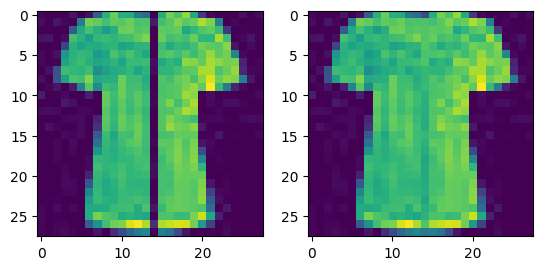

In [15]:
# Reshape data and plot original image
data = data.reshape(128, 28, 28)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(data[0, :, :].detach().numpy())

# Update data with output and plot updated image
data[0:, :, 14] = output[0, :]
ax2.imshow(data[0, :, :].detach().numpy())

plt.show()

# Implement an MLP with Leaky ReLU activation function enhancing with Batch Normalization layers

In [16]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = torch.nn.Linear(28 * 28, 256)
        self.batch_norm = torch.nn.BatchNorm1d(256)
        self.leaky_relu = torch.nn.LeakyReLU()
        self.hidden1 = torch.nn.Linear(256, 64)
        self.batch_norm1 = torch.nn.BatchNorm1d(64)
        self.leaky_relu1 = torch.nn.LeakyReLU()
        self.output = torch.nn.Linear(64, 28)

    def forward(self, x):
        x = x.to(torch.float32)
        x = x.view(-1, 28*28)
        x = self.hidden(x)
        x = self.batch_norm(x)
        x = self.leaky_relu(x)
        x = self.hidden1(x)
        x = self.batch_norm1(x)
        x = self.leaky_relu1(x)
        x = self.output(x)

        return x


In [17]:
net = NeuralNetwork()
net.train()
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9) # Define the optimizer
criterion = nn.MSELoss() #Define the loss function
n_epochs = 10

In [18]:
test_loss_min = np.Inf # set initial "min" to infinity


for epoch in range(n_epochs):
    train_loss = 0.0
    test_loss = 0.0
 
    net.train() 
    for data, target in train_dataloader:
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    net.eval()
    for data, target in test_dataloader:
      
      output = net(data)
      loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)

        
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_dataloader.dataset)
    test_loss = test_loss/len(test_dataloader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \ttest Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        test_loss
        ))
    
    # save model if validation loss has decreased
    if test_loss <= test_loss_min:
        print('Model saved - Validation loss decreased from {:.6f} to {:.6f}'.format(
        test_loss_min,
        test_loss))
        torch.save(net.state_dict(), 'model.pt')
        test_loss_min = test_loss

print('\n')
print('Process has finished.')

Epoch: 1 	Training Loss: 0.052828 	test Loss: 0.029462
Model saved - Validation loss decreased from inf to 0.029462
Epoch: 2 	Training Loss: 0.028543 	test Loss: 0.025548
Model saved - Validation loss decreased from 0.029462 to 0.025548
Epoch: 3 	Training Loss: 0.025808 	test Loss: 0.023697
Model saved - Validation loss decreased from 0.025548 to 0.023697
Epoch: 4 	Training Loss: 0.024156 	test Loss: 0.022229
Model saved - Validation loss decreased from 0.023697 to 0.022229
Epoch: 5 	Training Loss: 0.022956 	test Loss: 0.021267
Model saved - Validation loss decreased from 0.022229 to 0.021267
Epoch: 6 	Training Loss: 0.022184 	test Loss: 0.020508
Model saved - Validation loss decreased from 0.021267 to 0.020508
Epoch: 7 	Training Loss: 0.021328 	test Loss: 0.019888
Model saved - Validation loss decreased from 0.020508 to 0.019888
Epoch: 8 	Training Loss: 0.020814 	test Loss: 0.019377
Model saved - Validation loss decreased from 0.019888 to 0.019377
Epoch: 9 	Training Loss: 0.020183 	te

In [19]:
data, target = next(iter(test_dataloader))
net.eval()
output = net(data)
print(output.shape)

torch.Size([128, 28])


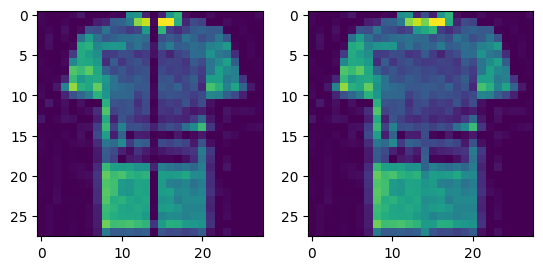

In [20]:
# Reshape data and plot original image
data = data.reshape(128, 28, 28)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(data[0, :, :].detach().numpy())

# Update data with output and plot updated image
data[0:, :, 14] = output[0, :]
ax2.imshow(data[0, :, :].detach().numpy())

plt.show()

# Implement an MLP with Leaky ReLU activation function enhancing with Dropout layers(dp rate = 0.5)


In [21]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self, dropout_prob=0.5):
        super().__init__()
        self.hidden = torch.nn.Linear(28 * 28, 256)
        self.dropout = torch.nn.Dropout(dropout_prob)
        self.leaky_relu = torch.nn.LeakyReLU()
        self.hidden1 = torch.nn.Linear(256, 64)
        self.dropout1 = torch.nn.Dropout(dropout_prob)
        self.leaky_relu1 = torch.nn.LeakyReLU()
        self.output = torch.nn.Linear(64, 28)

    def forward(self, x):
        x = x.to(torch.float32)
        x = x.view(-1, 28*28)
        x = self.hidden(x)
        x = self.dropout(x)
        x = self.leaky_relu(x)
        x = self.hidden1(x)
        x = self.dropout1(x)
        x = self.leaky_relu1(x)
        x = self.output(x)

        return x


In [22]:
net = NeuralNetwork()
net.train()
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9) # Define the optimizer
criterion = nn.MSELoss() #Define the loss function
n_epochs = 10

In [23]:
test_loss_min = np.Inf # set initial "min" to infinity


for epoch in range(n_epochs):
    train_loss = 0.0
    test_loss = 0.0
 
    net.train() 
    for data, target in train_dataloader:
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    net.eval()
    for data, target in test_dataloader:
      
      output = net(data)
      loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)

        
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_dataloader.dataset)
    test_loss = test_loss/len(test_dataloader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \ttest Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        test_loss
        ))
    
    # save model if validation loss has decreased
    if test_loss <= test_loss_min:
        print('Model saved - Validation loss decreased from {:.6f} to {:.6f}'.format(
        test_loss_min,
        test_loss))
        torch.save(net.state_dict(), 'model.pt')
        test_loss_min = test_loss

print('\n')
print('Process has finished.')

Epoch: 1 	Training Loss: 0.112594 	test Loss: 0.061013
Model saved - Validation loss decreased from inf to 0.061013
Epoch: 2 	Training Loss: 0.071572 	test Loss: 0.050581
Model saved - Validation loss decreased from 0.061013 to 0.050581
Epoch: 3 	Training Loss: 0.063233 	test Loss: 0.045285
Model saved - Validation loss decreased from 0.050581 to 0.045285
Epoch: 4 	Training Loss: 0.058470 	test Loss: 0.040497
Model saved - Validation loss decreased from 0.045285 to 0.040497
Epoch: 5 	Training Loss: 0.055203 	test Loss: 0.038707
Model saved - Validation loss decreased from 0.040497 to 0.038707
Epoch: 6 	Training Loss: 0.053050 	test Loss: 0.038607
Model saved - Validation loss decreased from 0.038707 to 0.038607
Epoch: 7 	Training Loss: 0.051276 	test Loss: 0.035805
Model saved - Validation loss decreased from 0.038607 to 0.035805
Epoch: 8 	Training Loss: 0.049829 	test Loss: 0.034156
Model saved - Validation loss decreased from 0.035805 to 0.034156
Epoch: 9 	Training Loss: 0.048891 	te

In [24]:
data, target = next(iter(test_dataloader))
net.eval()
output = net(data)
print(output.shape)

torch.Size([128, 28])


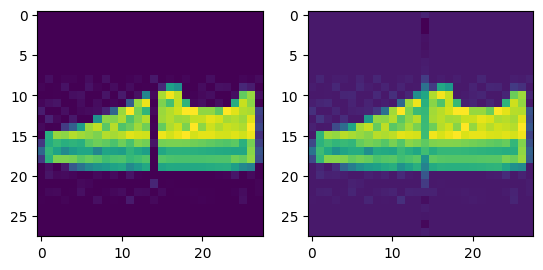

In [25]:
# Reshape data and plot original image
data = data.reshape(128, 28, 28)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(data[0, :, :].detach().numpy())

# Update data with output and plot updated image
data[0:, :, 14] = output[0, :]
ax2.imshow(data[0, :, :].detach().numpy())

plt.show()

# Implement an MLP with Leaky ReLU activation function enhancing with Dropout layers(dp rate = 0.1)


In [26]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self, dropout_prob=0.1):
        super().__init__()
        self.hidden = torch.nn.Linear(28 * 28, 256)
        self.dropout = torch.nn.Dropout(dropout_prob)
        self.leaky_relu = torch.nn.LeakyReLU()
        self.hidden1 = torch.nn.Linear(256, 64)
        self.dropout1 = torch.nn.Dropout(dropout_prob)
        self.leaky_relu1 = torch.nn.LeakyReLU()
        self.output = torch.nn.Linear(64, 28)

    def forward(self, x):
        x = x.to(torch.float32)
        x = x.view(-1, 28*28)
        x = self.hidden(x)
        x = self.dropout(x)
        x = self.leaky_relu(x)
        x = self.hidden1(x)
        x = self.dropout1(x)
        x = self.leaky_relu1(x)
        x = self.output(x)

        return x


In [27]:
net = NeuralNetwork()
net.train()
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9) # Define the optimizer
criterion = nn.MSELoss() #Define the loss function
n_epochs = 10

In [28]:
test_loss_min = np.Inf # set initial "min" to infinity


for epoch in range(n_epochs):
    train_loss = 0.0
    test_loss = 0.0
 
    net.train() 
    for data, target in train_dataloader:
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    net.eval()
    for data, target in test_dataloader:
      
      output = net(data)
      loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)

        
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_dataloader.dataset)
    test_loss = test_loss/len(test_dataloader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \ttest Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        test_loss
        ))
    
    # save model if validation loss has decreased
    if test_loss <= test_loss_min:
        print('Model saved - Validation loss decreased from {:.6f} to {:.6f}'.format(
        test_loss_min,
        test_loss))
        torch.save(net.state_dict(), 'model.pt')
        test_loss_min = test_loss

print('\n')
print('Process has finished.')

Epoch: 1 	Training Loss: 0.079283 	test Loss: 0.045331
Model saved - Validation loss decreased from inf to 0.045331
Epoch: 2 	Training Loss: 0.045893 	test Loss: 0.035172
Model saved - Validation loss decreased from 0.045331 to 0.035172
Epoch: 3 	Training Loss: 0.039487 	test Loss: 0.031742
Model saved - Validation loss decreased from 0.035172 to 0.031742
Epoch: 4 	Training Loss: 0.036548 	test Loss: 0.029690
Model saved - Validation loss decreased from 0.031742 to 0.029690
Epoch: 5 	Training Loss: 0.034683 	test Loss: 0.028377
Model saved - Validation loss decreased from 0.029690 to 0.028377
Epoch: 6 	Training Loss: 0.033310 	test Loss: 0.027374
Model saved - Validation loss decreased from 0.028377 to 0.027374
Epoch: 7 	Training Loss: 0.032244 	test Loss: 0.026455
Model saved - Validation loss decreased from 0.027374 to 0.026455
Epoch: 8 	Training Loss: 0.031273 	test Loss: 0.025742
Model saved - Validation loss decreased from 0.026455 to 0.025742
Epoch: 9 	Training Loss: 0.030576 	te

In [29]:
data, target = next(iter(test_dataloader))
net.eval()
output = net(data)
print(output.shape)

torch.Size([128, 28])


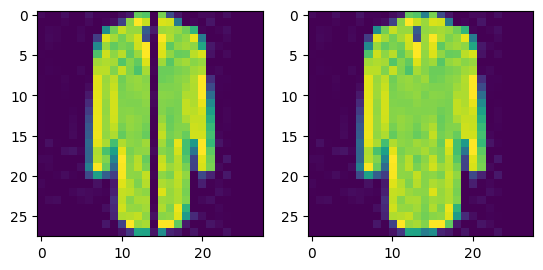

In [30]:
# Reshape data and plot original image
data = data.reshape(128, 28, 28)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(data[0, :, :].detach().numpy())

# Update data with output and plot updated image
data[0:, :, 14] = output[0, :]
ax2.imshow(data[0, :, :].detach().numpy())

plt.show()

# Implement an MLP with Leaky ReLU activation function

In [31]:
# build neural network
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = torch.nn.Linear(28 * 28, 256)
        self.sigmoid = torch.nn.Sigmoid()
        self.hidden1 = torch.nn.Linear(256, 64)
        self.sigmoid1 = torch.nn.Sigmoid()
        self.output = torch.nn.Linear(64, 28)

    def forward(self, x):
        x = x.to(torch.float32)
        x = x.view(-1, 28*28)
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.hidden1(x)
        x = self.sigmoid1(x)
        x = self.output(x)

        return x


In [32]:
net = NeuralNetwork()
net.train()
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9) # Define the optimizer
criterion = nn.MSELoss() #Define the loss function
n_epochs = 10

In [33]:
test_loss_min = np.Inf # set initial "min" to infinity


for epoch in range(n_epochs):
    train_loss = 0.0
    test_loss = 0.0
 
    net.train() 
    for data, target in train_dataloader:
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    net.eval()
    for data, target in test_dataloader:
      
      output = net(data)
      loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)

        
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_dataloader.dataset)
    test_loss = test_loss/len(test_dataloader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \ttest Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        test_loss
        ))
    
    # save model if validation loss has decreased
    if test_loss <= test_loss_min:
        print('Model saved - Validation loss decreased from {:.6f} to {:.6f}'.format(
        test_loss_min,
        test_loss))
        torch.save(net.state_dict(), 'model.pt')
        test_loss_min = test_loss

print('\n')
print('Process has finished.')

Epoch: 1 	Training Loss: 0.119704 	test Loss: 0.110153
Model saved - Validation loss decreased from inf to 0.110153
Epoch: 2 	Training Loss: 0.105895 	test Loss: 0.099854
Model saved - Validation loss decreased from 0.110153 to 0.099854
Epoch: 3 	Training Loss: 0.090202 	test Loss: 0.079917
Model saved - Validation loss decreased from 0.099854 to 0.079917
Epoch: 4 	Training Loss: 0.073005 	test Loss: 0.069324
Model saved - Validation loss decreased from 0.079917 to 0.069324
Epoch: 5 	Training Loss: 0.067097 	test Loss: 0.065783
Model saved - Validation loss decreased from 0.069324 to 0.065783
Epoch: 6 	Training Loss: 0.063474 	test Loss: 0.061774
Model saved - Validation loss decreased from 0.065783 to 0.061774
Epoch: 7 	Training Loss: 0.059139 	test Loss: 0.057257
Model saved - Validation loss decreased from 0.061774 to 0.057257
Epoch: 8 	Training Loss: 0.054930 	test Loss: 0.053543
Model saved - Validation loss decreased from 0.057257 to 0.053543
Epoch: 9 	Training Loss: 0.051838 	te

In [34]:
data, target = next(iter(test_dataloader))
net.eval()
output = net(data)
print(output.shape)

torch.Size([128, 28])


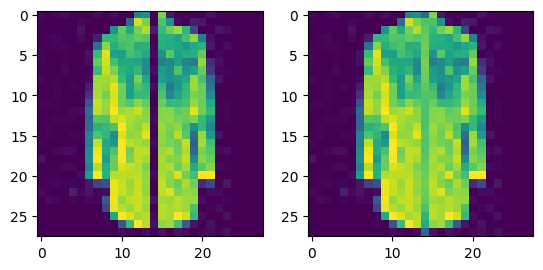

In [35]:
# Reshape data and plot original image
data = data.reshape(128, 28, 28)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(data[0, :, :].detach().numpy())

# Update data with output and plot updated image
data[0:, :, 14] = output[0, :]
ax2.imshow(data[0, :, :].detach().numpy())

plt.show()

# Implement an MLP with ReLU activation function

In [34]:
import torch

class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = torch.nn.Linear(28 * 28, 256)
        self.relu = torch.nn.ReLU()
        self.hidden1 = torch.nn.Linear(256, 64)
        self.relu1 = torch.nn.ReLU()
        self.output = torch.nn.Linear(64, 28)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.hidden(x)
        x = self.relu(x)
        x = self.hidden1(x)
        x = self.relu1(x)
        x = self.output(x)

        return x


In [35]:
net = NeuralNetwork()
net.train()
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9) # Define the optimizer
criterion = nn.MSELoss() #Define the loss function
n_epochs = 10

In [36]:
test_loss_min = np.Inf # set initial "min" to infinity


for epoch in range(n_epochs):
    train_loss = 0.0
    test_loss = 0.0
 
    net.train() 
    for data, target in train_dataloader:
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    net.eval()
    for data, target in test_dataloader:
      
      output = net(data)
      loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)

        
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_dataloader.dataset)
    test_loss = test_loss/len(test_dataloader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \ttest Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        test_loss
        ))
    
    # save model if validation loss has decreased
    if test_loss <= test_loss_min:
        print('Model saved - Validation loss decreased from {:.6f} to {:.6f}'.format(
        test_loss_min,
        test_loss))
        torch.save(net.state_dict(), 'model.pt')
        test_loss_min = test_loss

print('\n')
print('Process has finished.')

Epoch: 1 	Training Loss: 0.076255 	test Loss: 0.045788
Model saved - Validation loss decreased from inf to 0.045788
Epoch: 2 	Training Loss: 0.039185 	test Loss: 0.034369
Model saved - Validation loss decreased from 0.045788 to 0.034369
Epoch: 3 	Training Loss: 0.032167 	test Loss: 0.030374
Model saved - Validation loss decreased from 0.034369 to 0.030374
Epoch: 4 	Training Loss: 0.029462 	test Loss: 0.028438
Model saved - Validation loss decreased from 0.030374 to 0.028438
Epoch: 5 	Training Loss: 0.027834 	test Loss: 0.027166
Model saved - Validation loss decreased from 0.028438 to 0.027166
Epoch: 6 	Training Loss: 0.026574 	test Loss: 0.025972
Model saved - Validation loss decreased from 0.027166 to 0.025972
Epoch: 7 	Training Loss: 0.025552 	test Loss: 0.024994
Model saved - Validation loss decreased from 0.025972 to 0.024994
Epoch: 8 	Training Loss: 0.024694 	test Loss: 0.024227
Model saved - Validation loss decreased from 0.024994 to 0.024227
Epoch: 9 	Training Loss: 0.023959 	te

In [37]:
data, target = next(iter(test_dataloader))
net.eval()
output = net(data)
print(output.shape)

torch.Size([128, 28])


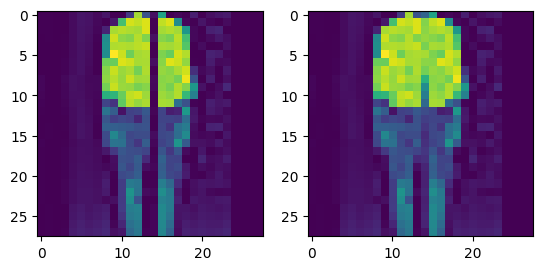

In [38]:
# Reshape data and plot original image
data = data.reshape(128, 28, 28)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(data[0, :, :].detach().numpy())

# Update data with output and plot updated image
data[0:, :, 14] = output[0, :]
ax2.imshow(data[0, :, :].detach().numpy())

plt.show()

# enhancing with Learning rate scheduling


In [39]:
# build neural network
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = torch.nn.Linear(28 * 28, 256)
        self.leaky_relu = torch.nn.LeakyReLU()
        self.hidden1 = torch.nn.Linear(256, 64)
        self.leaky_relu1 = torch.nn.LeakyReLU()
        self.output = torch.nn.Linear(64, 28)

    def forward(self, x):
        x = x.to(torch.float32)
        x = x.view(-1, 28*28)
        x = self.hidden(x)
        x = self.leaky_relu(x)
        x = self.hidden1(x)
        x = self.leaky_relu1(x)
        x = self.output(x)

        return x


In [40]:
net = NeuralNetwork()
net.train()
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9) # Define the optimizer
criterion = nn.MSELoss() #Define the loss function
n_epochs = 10

In [41]:
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [42]:
test_loss_min = np.Inf  # set initial "min" to infinity


for epoch in range(n_epochs):
    train_loss = 0.0
    test_loss = 0.0

    net.train()
    for data, target in train_dataloader:
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    net.eval()
    for data, target in test_dataloader:

        output = net(data)
        loss = criterion(output, target)
        test_loss += loss.item()*data.size(0)

    # calculate average loss over an epoch
    train_loss = train_loss/len(train_dataloader.dataset)
    test_loss = test_loss/len(test_dataloader.dataset)

    scheduler.step()  # adjust the learning rate

    print('Epoch: {} \tTraining Loss: {:.6f} \tTest Loss: {:.6f} \tLearning Rate: {:.6f}'.format(
        epoch+1,
        train_loss,
        test_loss,
        scheduler.get_last_lr()[0]
    ))

    # save model if validation loss has decreased
    if test_loss <= test_loss_min:
        print('Model saved - Validation loss decreased from {:.6f} to {:.6f}'.format(
        test_loss_min,
        test_loss))
        torch.save(net.state_dict(), 'model.pt')
        test_loss_min = test_loss

print('\n')
print('Process has finished.')

Epoch: 1 	Training Loss: 0.074654 	Test Loss: 0.045697 	Learning Rate: 0.010000
Model saved - Validation loss decreased from inf to 0.045697
Epoch: 2 	Training Loss: 0.038335 	Test Loss: 0.033414 	Learning Rate: 0.010000
Model saved - Validation loss decreased from 0.045697 to 0.033414
Epoch: 3 	Training Loss: 0.031496 	Test Loss: 0.029755 	Learning Rate: 0.010000
Model saved - Validation loss decreased from 0.033414 to 0.029755
Epoch: 4 	Training Loss: 0.028931 	Test Loss: 0.027811 	Learning Rate: 0.010000
Model saved - Validation loss decreased from 0.029755 to 0.027811
Epoch: 5 	Training Loss: 0.027301 	Test Loss: 0.026387 	Learning Rate: 0.001000
Model saved - Validation loss decreased from 0.027811 to 0.026387
Epoch: 6 	Training Loss: 0.026514 	Test Loss: 0.026249 	Learning Rate: 0.001000
Model saved - Validation loss decreased from 0.026387 to 0.026249
Epoch: 7 	Training Loss: 0.026389 	Test Loss: 0.026125 	Learning Rate: 0.001000
Model saved - Validation loss decreased from 0.02

In [43]:
data, target = next(iter(test_dataloader))
net.eval()
output = net(data)
print(output.shape)

torch.Size([128, 28])


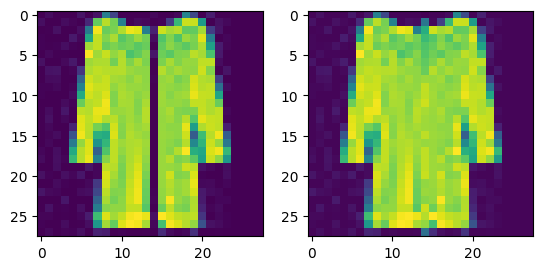

In [44]:
# Reshape data and plot original image
data = data.reshape(128, 28, 28)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(data[0, :, :].detach().numpy())

# Update data with output and plot updated image
data[0:, :, 14] = output[0, :]
ax2.imshow(data[0, :, :].detach().numpy())

plt.show()

# L1 Regularization


In [45]:
# build neural network
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = torch.nn.Linear(28 * 28, 256)
        self.sigmoid = torch.nn.Sigmoid()
        self.hidden1 = torch.nn.Linear(256, 64)
        self.sigmoid1 = torch.nn.Sigmoid()
        self.output = torch.nn.Linear(64, 28)

    def forward(self, x):
        x = x.to(torch.float32)
        x = x.view(-1, 28*28)
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.hidden1(x)
        x = self.sigmoid1(x)
        x = self.output(x)

        return x
    

In [46]:
net = NeuralNetwork()
net.train()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001) # Define the optimizer with L1 regularization
criterion = nn.MSELoss() # Define the loss function
n_epochs = 10

In [47]:
test_loss_min = np.Inf # set initial "min" to infinity

for epoch in range(n_epochs):
    train_loss = 0.0
    test_loss = 0.0
 
    net.train() 
    for data, target in train_dataloader:
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        
        # add L1 penalty term to the loss function
        l1_lambda = 0.001
        l1_norm = sum(p.abs().sum() for p in net.parameters())
        loss += l1_lambda * l1_norm

        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    net.eval()
    for data, target in test_dataloader:
      
      output = net(data)
      loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)

    # calculate average loss over an epoch
    train_loss = train_loss/len(train_dataloader.dataset)
    test_loss = test_loss/len(test_dataloader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tTest Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        test_loss
        ))
    
    # save model if validation loss has decreased
    if test_loss <= test_loss_min:
        print('Model saved - Validation loss decreased from {:.6f} to {:.6f}'.format(
        test_loss_min,
        test_loss))
        torch.save(net.state_dict(), 'model.pt')
        test_loss_min = test_loss

print('\n')
print('Process has finished.')

Epoch: 1 	Training Loss: 1.685216 	Test Loss: 0.115343
Model saved - Validation loss decreased from inf to 0.115343
Epoch: 2 	Training Loss: 0.172949 	Test Loss: 0.115488
Epoch: 3 	Training Loss: 0.140955 	Test Loss: 0.116455
Epoch: 4 	Training Loss: 0.139938 	Test Loss: 0.115615
Epoch: 5 	Training Loss: 0.139089 	Test Loss: 0.115996
Epoch: 6 	Training Loss: 0.138274 	Test Loss: 0.116087
Epoch: 7 	Training Loss: 0.137511 	Test Loss: 0.115868
Epoch: 8 	Training Loss: 0.136775 	Test Loss: 0.116025
Epoch: 9 	Training Loss: 0.136058 	Test Loss: 0.115564
Epoch: 10 	Training Loss: 0.135375 	Test Loss: 0.115790


Process has finished.


In [48]:
data, target = next(iter(test_dataloader))
net.eval()
output = net(data)
print(output.shape)

torch.Size([128, 28])


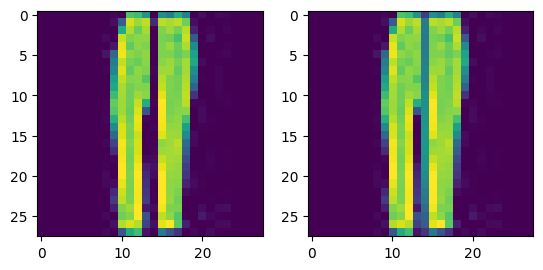

In [49]:
# Reshape data and plot original image
data = data.reshape(128, 28, 28)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(data[0, :, :].detach().numpy())

# Update data with output and plot updated image
data[0:, :, 14] = output[0, :]
ax2.imshow(data[0, :, :].detach().numpy())

plt.show()

# L2 Regularization

In [12]:
# build neural network
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = torch.nn.Linear(28 * 28, 256)
        self.sigmoid = torch.nn.Sigmoid()
        self.hidden1 = torch.nn.Linear(256, 64)
        self.sigmoid1 = torch.nn.Sigmoid()
        self.output = torch.nn.Linear(64, 28)

    def forward(self, x):
        x = x.to(torch.float32)
        x = x.view(-1, 28*28)
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.hidden1(x)
        x = self.sigmoid1(x)
        x = self.output(x)

        return x


In [13]:
net = NeuralNetwork()
net.train()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-5)  # Define the optimizer with L2 regularization
criterion = nn.MSELoss()  # Define the loss function
n_epochs = 10

In [14]:
test_loss_min = np.Inf  # set initial "min" to infinity

for epoch in range(n_epochs):
    train_loss = 0.0
    test_loss = 0.0

    net.train() 
    for data, target in train_dataloader:
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    net.eval()
    for data, target in test_dataloader:
        output = net(data)
        loss = criterion(output, target)
        test_loss += loss.item()*data.size(0)

    # calculate average loss over an epoch
    train_loss = train_loss/len(train_dataloader.dataset)
    test_loss = test_loss/len(test_dataloader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f} \tTest Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        test_loss
    ))

    # save model if validation loss has decreased
    if test_loss <= test_loss_min:
        print('Model saved - Validation loss decreased from {:.6f} to {:.6f}'.format(
            test_loss_min,
            test_loss
        ))
        torch.save(net.state_dict(), 'model.pt')
        test_loss_min = test_loss

print('\n')
print('Process has finished.')

Epoch: 1 	Training Loss: 0.119602 	Test Loss: 0.109965
Model saved - Validation loss decreased from inf to 0.109965
Epoch: 2 	Training Loss: 0.103407 	Test Loss: 0.096537
Model saved - Validation loss decreased from 0.109965 to 0.096537
Epoch: 3 	Training Loss: 0.085279 	Test Loss: 0.075964
Model saved - Validation loss decreased from 0.096537 to 0.075964
Epoch: 4 	Training Loss: 0.071150 	Test Loss: 0.068666
Model saved - Validation loss decreased from 0.075964 to 0.068666
Epoch: 5 	Training Loss: 0.066745 	Test Loss: 0.065209
Model saved - Validation loss decreased from 0.068666 to 0.065209
Epoch: 6 	Training Loss: 0.062923 	Test Loss: 0.060938
Model saved - Validation loss decreased from 0.065209 to 0.060938
Epoch: 7 	Training Loss: 0.058553 	Test Loss: 0.056596
Model saved - Validation loss decreased from 0.060938 to 0.056596
Epoch: 8 	Training Loss: 0.054770 	Test Loss: 0.053428
Model saved - Validation loss decreased from 0.056596 to 0.053428
Epoch: 9 	Training Loss: 0.052106 	Te

In [15]:
data, target = next(iter(test_dataloader))
net.eval()
output = net(data)
print(output.shape)

torch.Size([128, 28])


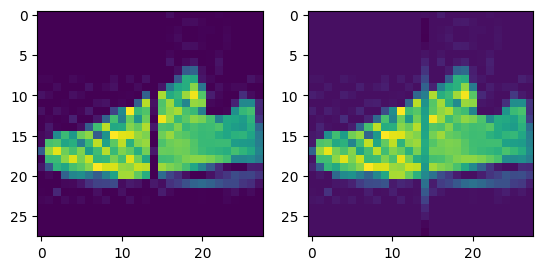

In [16]:
# Reshape data and plot original image
data = data.reshape(128, 28, 28)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(data[0, :, :].detach().numpy())

# Update data with output and plot updated image
data[0:, :, 14] = output[0, :]
ax2.imshow(data[0, :, :].detach().numpy())

plt.show()

# Different Weight initialization


In [17]:
# Define a custom weight initialization function
def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_normal_(m.weight.data)
        m.bias.data.fill_(0.01)

In [18]:
# Build neural network with custom weight initialization
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = torch.nn.Linear(28 * 28, 256)
        self.sigmoid = torch.nn.Sigmoid()
        self.hidden1 = torch.nn.Linear(256, 64)
        self.sigmoid1 = torch.nn.Sigmoid()
        self.output = torch.nn.Linear(64, 28)
        
        # Apply custom weight initialization
        self.apply(init_weights)

    def forward(self, x):
        x = x.to(torch.float32)
        x = x.view(-1, 28*28)
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.hidden1(x)
        x = self.sigmoid1(x)
        x = self.output(x)

        return x


In [19]:
net = NeuralNetwork()
net.train()
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9) # Define the optimizer
criterion = nn.MSELoss() #Define the loss function
n_epochs = 10

In [20]:
test_loss_min = np.Inf # set initial "min" to infinity

for epoch in range(n_epochs):
    train_loss = 0.0
    test_loss = 0.0
 
    net.train() 
    for data, target in train_dataloader:
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    net.eval()
    for data, target in test_dataloader:
      
      output = net(data)
      loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)

        
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_dataloader.dataset)
    test_loss = test_loss/len(test_dataloader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \ttest Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        test_loss
        ))
    
    # save model if validation loss has decreased
    if test_loss <= test_loss_min:
        print('Model saved - Validation loss decreased from {:.6f} to {:.6f}'.format(
        test_loss_min,
        test_loss))
        torch.save(net.state_dict(), 'model.pt')
        test_loss_min = test_loss

print('\n')
print('Process has finished.')

Epoch: 1 	Training Loss: 0.112299 	test Loss: 0.084855
Model saved - Validation loss decreased from inf to 0.084855
Epoch: 2 	Training Loss: 0.071916 	test Loss: 0.062945
Model saved - Validation loss decreased from 0.084855 to 0.062945
Epoch: 3 	Training Loss: 0.057913 	test Loss: 0.054330
Model saved - Validation loss decreased from 0.062945 to 0.054330
Epoch: 4 	Training Loss: 0.051165 	test Loss: 0.048625
Model saved - Validation loss decreased from 0.054330 to 0.048625
Epoch: 5 	Training Loss: 0.046202 	test Loss: 0.044146
Model saved - Validation loss decreased from 0.048625 to 0.044146
Epoch: 6 	Training Loss: 0.042257 	test Loss: 0.040561
Model saved - Validation loss decreased from 0.044146 to 0.040561
Epoch: 7 	Training Loss: 0.039182 	test Loss: 0.037851
Model saved - Validation loss decreased from 0.040561 to 0.037851
Epoch: 8 	Training Loss: 0.036876 	test Loss: 0.035823
Model saved - Validation loss decreased from 0.037851 to 0.035823
Epoch: 9 	Training Loss: 0.035173 	te

In [21]:
data, target = next(iter(test_dataloader))
net.eval()
output = net(data)
print(output.shape)

torch.Size([128, 28])


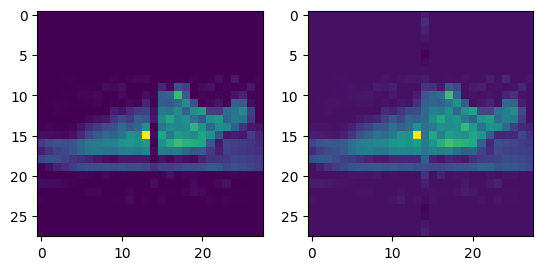

In [22]:
# Reshape data and plot original image
data = data.reshape(128, 28, 28)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(data[0, :, :].detach().numpy())

# Update data with output and plot updated image
data[0:, :, 14] = output[0, :]
ax2.imshow(data[0, :, :].detach().numpy())

plt.show()

# Early stopping

In [23]:
# build neural network
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = torch.nn.Linear(28 * 28, 256)
        self.sigmoid = torch.nn.Sigmoid()
        self.hidden1 = torch.nn.Linear(256, 64)
        self.sigmoid1 = torch.nn.Sigmoid()
        self.output = torch.nn.Linear(64, 28)

    def forward(self, x):
        x = x.to(torch.float32)
        x = x.view(-1, 28*28)
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.hidden1(x)
        x = self.sigmoid1(x)
        x = self.output(x)

        return x

In [24]:
net = NeuralNetwork()
net.train()
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9) # Define the optimizer
criterion = nn.MSELoss() #Define the loss function
n_epochs = 10

In [25]:
test_loss_min = np.Inf # set initial "min" to infinity
patience = 3 # set the number of epochs to wait before stopping

counter = 0 # initialize the counter variable to zero

for epoch in range(n_epochs):
    train_loss = 0.0
    test_loss = 0.0
 
    net.train() 
    for data, target in train_dataloader:
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    net.eval()
    for data, target in test_dataloader:
        output = net(data)
        loss = criterion(output, target)
        test_loss += loss.item()*data.size(0)

    # calculate average loss over an epoch
    train_loss = train_loss/len(train_dataloader.dataset)
    test_loss = test_loss/len(test_dataloader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \ttest Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        test_loss
        ))
    
    # save model if validation loss has decreased
    if test_loss <= test_loss_min:
        print('Model saved - Validation loss decreased from {:.6f} to {:.6f}'.format(
        test_loss_min,
        test_loss))
        torch.save(net.state_dict(), 'model.pt')
        test_loss_min = test_loss
        counter = 0 # reset the counter if validation loss decreases
    else:
        counter += 1 # increment the counter if validation loss does not decrease

    # stop training if validation loss has not decreased for a certain number of epochs
    if counter >= patience:
        print('Early stopping - validation loss has not decreased for {} epochs'.format(patience))
        break

print('\n')
print('Process has finished.')

Epoch: 1 	Training Loss: 0.118035 	test Loss: 0.109608
Model saved - Validation loss decreased from inf to 0.109608
Epoch: 2 	Training Loss: 0.103176 	test Loss: 0.096185
Model saved - Validation loss decreased from 0.109608 to 0.096185
Epoch: 3 	Training Loss: 0.085157 	test Loss: 0.076081
Model saved - Validation loss decreased from 0.096185 to 0.076081
Epoch: 4 	Training Loss: 0.071637 	test Loss: 0.069441
Model saved - Validation loss decreased from 0.076081 to 0.069441
Epoch: 5 	Training Loss: 0.067871 	test Loss: 0.066653
Model saved - Validation loss decreased from 0.069441 to 0.066653
Epoch: 6 	Training Loss: 0.064886 	test Loss: 0.063204
Model saved - Validation loss decreased from 0.066653 to 0.063204
Epoch: 7 	Training Loss: 0.060980 	test Loss: 0.058854
Model saved - Validation loss decreased from 0.063204 to 0.058854
Epoch: 8 	Training Loss: 0.056671 	test Loss: 0.054788
Model saved - Validation loss decreased from 0.058854 to 0.054788
Epoch: 9 	Training Loss: 0.053193 	te

In [26]:
data, target = next(iter(test_dataloader))
net.eval()
output = net(data)
print(output.shape)

torch.Size([128, 28])


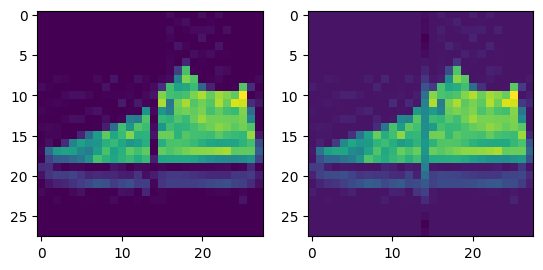

In [27]:
# Reshape data and plot original image
data = data.reshape(128, 28, 28)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(data[0, :, :].detach().numpy())

# Update data with output and plot updated image
data[0:, :, 14] = output[0, :]
ax2.imshow(data[0, :, :].detach().numpy())

plt.show()

# Utilizing different optimizers

In [28]:
# build neural network
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = torch.nn.Linear(28 * 28, 256)
        self.sigmoid = torch.nn.Sigmoid()
        self.hidden1 = torch.nn.Linear(256, 64)
        self.sigmoid1 = torch.nn.Sigmoid()
        self.output = torch.nn.Linear(64, 28)

    def forward(self, x):
        x = x.to(torch.float32)
        x = x.view(-1, 28*28)
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.hidden1(x)
        x = self.sigmoid1(x)
        x = self.output(x)

        return x

In [29]:
net = NeuralNetwork()
net.train()

NeuralNetwork(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (sigmoid): Sigmoid()
  (hidden1): Linear(in_features=256, out_features=64, bias=True)
  (sigmoid1): Sigmoid()
  (output): Linear(in_features=64, out_features=28, bias=True)
)

In [30]:
# Define the list of optimizers
optimizers = [optim.SGD(net.parameters(), lr=0.01, momentum=0.9),
              optim.Adam(net.parameters(), lr=0.001),
              optim.RMSprop(net.parameters(), lr=0.01)]

# Define the loss function
criterion = nn.MSELoss()

# Define the number of epochs
n_epochs = 10


In [31]:
# Set initial "min" to infinity
test_loss_min = np.Inf

for optimizer in optimizers:
    print(f"\nOptimizer: {optimizer}")

    for epoch in range(n_epochs):
        train_loss = 0.0
        test_loss = 0.0

        # Set the network to train mode
        net.train() 

        # Loop through the training data
        for data, target in train_dataloader:
            # Zero out the gradients
            optimizer.zero_grad()

            # Forward pass
            output = net(data)

            # Calculate the loss
            loss = criterion(output, target)

            # Backward pass
            loss.backward()

            # Update the weights
            optimizer.step()

            # Accumulate the training loss
            train_loss += loss.item()*data.size(0)

        # Set the network to evaluation mode
        net.eval()

        # Loop through the testing data
        for data, target in test_dataloader:
            # Forward pass
            output = net(data)

            # Calculate the loss
            loss = criterion(output, target)

            # Accumulate the testing loss
            test_loss += loss.item()*data.size(0)

        # Calculate the average loss over an epoch
        train_loss = train_loss/len(train_dataloader.dataset)
        test_loss = test_loss/len(test_dataloader.dataset)

        # Print the loss for this epoch
        print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss:.6f} \tTest Loss: {test_loss:.6f}')

        # Save the model if the validation loss has decreased
        if test_loss <= test_loss_min:
            print(f'Model saved - Validation loss decreased from {test_loss_min:.6f} to {test_loss:.6f}')
            torch.save(net.state_dict(), 'model.pt')
            test_loss_min = test_loss

print('\nProcess has finished.')


Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
Epoch: 1 	Training Loss: 0.119086 	Test Loss: 0.111101
Model saved - Validation loss decreased from inf to 0.111101
Epoch: 2 	Training Loss: 0.106134 	Test Loss: 0.101287
Model saved - Validation loss decreased from 0.111101 to 0.101287
Epoch: 3 	Training Loss: 0.091150 	Test Loss: 0.081027
Model saved - Validation loss decreased from 0.101287 to 0.081027
Epoch: 4 	Training Loss: 0.073186 	Test Loss: 0.068800
Model saved - Validation loss decreased from 0.081027 to 0.068800
Epoch: 5 	Training Loss: 0.066378 	Test Loss: 0.064485
Model saved - Validation loss decreased from 0.068800 to 0.064485
Epoch: 6 	Training Loss: 0.062093 	Test Loss: 0.059922
Model saved - Validation loss decreased from 0.064485 to 0.059922
Epoch: 7 	Training Loss: 0.057486 	Test Loss: 0.055507
Model saved - Validation loss decr